# 03 — Customer Contribution Analysis

This notebook analyses customer contribution using the reporting mart (`report_customers_sample`). It surfaces top customers and revenue concentration — useful for account management and commercial planning.

In [1]:
import sys
from pathlib import Path

# Add project root to Python path so `from src...` imports work when running from /notebooks
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


In [2]:
import pandas as pd
import numpy as np

from src.io import load_sample
from src import quality, kpi_metrics as metrics
from src.viz import line_chart, barh_top

dfs = load_sample()
fact = dfs["fact_sales"]
dim_customers = dfs["dim_customers"]
dim_products = dfs["dim_products"]
report_customers = dfs["report_customers"]
report_products = dfs["report_products"]

fact.head()


,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
0,SO54496,282,5400,2013-03-16,2013-03-23,2013-03-28,25,1,25
1,SO54496,289,5400,2013-03-16,2013-03-23,2013-03-28,5,1,5
2,SO54496,259,5400,2013-03-16,2013-03-23,2013-03-28,2,1,2
3,SO54497,174,9281,2013-03-16,2013-03-23,2013-03-28,22,1,22
4,SO54497,280,9281,2013-03-16,2013-03-23,2013-03-28,9,1,9


In [ ]:
# Schema validation (fail fast if inputs change)
from src.core.schema_checks import assert_required_columns, REQUIRED

assert_required_columns(fact, REQUIRED["fact_sales"], "fact_sales")
assert_required_columns(dim_customers, REQUIRED["dim_customers"], "dim_customers")
assert_required_columns(dim_products, REQUIRED["dim_products"], "dim_products")

In [3]:
from src.core import ensure_output_dirs
ensure_output_dirs()


{'base': WindowsPath('outputs'),
 'tables': WindowsPath('outputs/tables'),
 'figures': WindowsPath('outputs/figures')}

In [5]:
# Top customers by total sales (from report mart)
top = report_customers.sort_values("total_sales", ascending=False).head(20)
top[["customer_name","customer_segment","total_sales","total_orders","avg_order_value"]].head(10)


,customer_name,customer_segment,total_sales,total_orders,avg_order_value
1088,Kaitlyn Henderson,VIP,13294,5,2658
1257,Nichole Nara,VIP,13294,5,2658
1264,Margaret He,VIP,13268,5,2653
1087,Randall Dominguez,VIP,13265,5,2653
1256,Adriana Gonzalez,VIP,13242,5,2648
1277,Rosa Hu,VIP,13215,5,2643
1080,Brandi Gill,VIP,13195,5,2639
1263,Brad She,VIP,13172,5,2634
1252,Francisco Sara,VIP,13164,5,2632
389,Maurice Shan,New,12914,6,2152


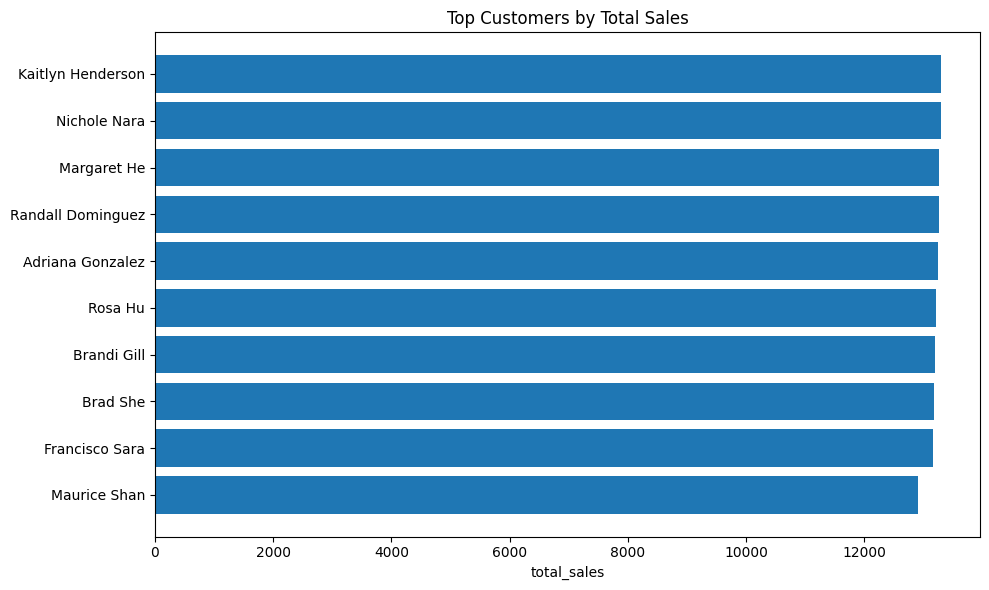

'outputs/figures/top_customers_sales.png'

In [6]:
fig_path = "outputs/figures/top_customers_sales.png"
barh_top(top, "customer_name", "total_sales", "Top Customers by Total Sales", top_n=10, path=fig_path)
fig_path


In [7]:
# Segment summary (share of revenue)
seg = report_customers.groupby("customer_segment", dropna=False)["total_sales"].sum().sort_values(ascending=False)
seg_share = (seg / seg.sum() * 100).round(1)
pd.DataFrame({"revenue": seg, "share_pct": seg_share})


,revenue,share_pct
customer_segment,,
VIP,10458276,38.8
New,9143554,33.9
Regular,7367237,27.3


In [8]:
# Export top customers and segment summary
top_path = "outputs/tables/top_customers.csv"
seg_path = "outputs/tables/customer_segment_summary.csv"

top.to_csv(top_path, index=False)
pd.DataFrame({"segment": seg.index.astype(str), "revenue": seg.values, "share_pct": seg_share.values}).to_csv(seg_path, index=False)

(top_path, seg_path)


('outputs/tables/top_customers.csv',
 'outputs/tables/customer_segment_summary.csv')

In [ ]:
# Recruiter-friendly: dashboard preview at the end (no scrolling)
from IPython.display import Image, display

for fp in [
    "../powerbi/screenshots/dashboard_customer_360.png",
    "../powerbi/screenshots/dashboard_product_performance.png",
    "../powerbi/screenshots/dashboard_data_quality.png",
]:
    display(Image(filename=fp, width=1200))